# Previsão de Séries Temporais (Daily Minimum Temperatures — Melbourne)
**Modelos:** Prophet (clássico) e LSTM (deep learning)  
**Métricas:** MAE e MASE

**Dataset Kaggle:** Daily Minimum Temperatures in Melbourne (1981–1990)  
Link: https://www.kaggle.com/datasets/suprematism/daily-minimum-temperatures  :contentReference[oaicite:0]{index=0}


In [20]:
!pip -q install --upgrade \
    numpy==2.0.2 \
    pandas==2.2.2 \
    scipy==1.11.4 \
    scikit-learn==1.5.2 \
    matplotlib==3.8.4 \
    tensorflow==2.16.1 \
    prophet==1.1.5 \
    cmdstanpy==1.2.4

ERROR: Cannot install numpy==2.0.2, pandas==2.2.2 and scipy==1.11.4 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [21]:
!pip -q install -U sktime==0.34.0

import os, sys, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.base import ForecastingHorizon

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Como carregar os dados
Você pode:
1) **Baixar do Kaggle** (link acima) e fazer upload do `daily-min-temperatures.csv`, ou  
2) Usar a célula de upload abaixo no Colab.

> O notebook espera um arquivo com duas colunas `Date` (YYYY-MM-DD) e `Temp`.

In [22]:
import os, glob, pandas as pd
from zipfile import ZipFile

dataset_id = "suprematism/daily-minimum-temperatures"

!kaggle datasets download -d {dataset_id} -p /content -o

zips = glob.glob("/content/*.zip")
if not zips:
    raise FileNotFoundError("Zip do Kaggle não encontrado em /content.")
zip_path = zips[0]
print("Zip encontrado:", zip_path)

# Extrai
with ZipFile(zip_path, 'r') as zf:
    zf.extractall("/content")
print("Arquivos extraídos em /content")

csv_candidates = glob.glob("/content/**/*.csv", recursive=True)
if not csv_candidates:
    raise FileNotFoundError("Nenhum CSV encontrado após extração.")
csv_path = sorted(csv_candidates)[0]
print("CSV detectado:", csv_path)

df_raw = pd.read_csv(csv_path)

possible_date_cols = [c for c in df_raw.columns if c.strip().lower() in ("date","data")]
possible_value_cols = [c for c in df_raw.columns if c.strip().lower() in ("temp","temperature","valor","value")]

if not possible_date_cols or not possible_value_cols:
    print("Colunas detectadas:", df_raw.columns.tolist())
    raise ValueError("Não encontrei colunas 'Date' e 'Temp' (ou equivalentes). Ajuste os nomes abaixo.")

COL_DATE = possible_date_cols[0]
COL_VALUE = possible_value_cols[0]

df_raw[COL_DATE] = pd.to_datetime(df_raw[COL_DATE], dayfirst=True, errors="coerce")
df_raw = df_raw.dropna(subset=[COL_DATE]).reset_index(drop=True)

print(f"Lido: {os.path.basename(csv_path)}  |  Linhas: {len(df_raw)}")
display(df_raw.head())


Dataset URL: https://www.kaggle.com/datasets/suprematism/daily-minimum-temperatures
License(s): unknown
  0% 0.00/13.7k [00:00<?, ?B/s]
100% 13.7k/13.7k [00:00<00:00, 36.2MB/s]
Zip encontrado: /content/daily-minimum-temperatures.zip
Arquivos extraídos em /content
CSV detectado: /content/1_Daily_minimum_temps.csv
Lido: 1_Daily_minimum_temps.csv  |  Linhas: 3650


,Date,Temp
0,1981-01-01,20.7
1,1981-02-01,17.9
2,1981-03-01,18.8
3,1981-04-01,14.6
4,1981-05-01,15.8


,Temp
Date,
1981-01-01,20.7
1981-01-02,15.3
1981-01-03,17.8
1981-01-04,16.7
1981-01-05,8.6


,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


,Temp
count,3652.000000
mean,11.179587
std,4.071482
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


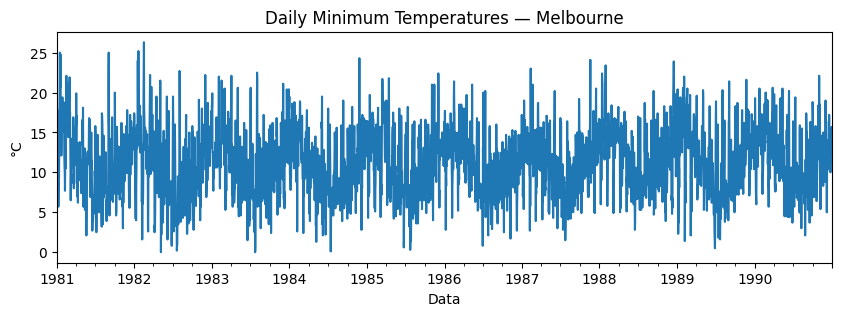

In [23]:
COL_DATE = 'Date'
COL_VALUE = 'Temp'
assert COL_DATE in df_raw.columns and COL_VALUE in df_raw.columns, df_raw.columns

df = df_raw[[COL_DATE, COL_VALUE]].copy()

df[COL_DATE] = pd.to_datetime(df[COL_DATE], dayfirst=True, errors='coerce')

s = (
    df[COL_VALUE]
    .astype(str).str.strip()
    .str.replace(',', '.', regex=False)
    .str.replace(r'[^0-9\.\-]+', '', regex=True)  # remove ?, °, etc.
)

df[COL_VALUE] = pd.to_numeric(s, errors='coerce')

bad = df[df[COL_VALUE].isna()]
if len(bad):
    print(f"Valores inválidos encontrados: {len(bad)} (serão descartados/interpolados)")
    display(bad.head())

df = df.dropna(subset=[COL_DATE]).sort_values(COL_DATE).reset_index(drop=True)

df = df.set_index(COL_DATE).asfreq('D')

df[COL_VALUE] = df[COL_VALUE].interpolate(method='time', limit_direction='both')

rest = df[COL_VALUE].isna().sum()
if rest:
    print(f"Restaram {rest} NaNs após interpolação — serão removidos.")
    df = df.dropna(subset=[COL_VALUE])

display(df.head(), df.tail(), df.describe())

ax = df[COL_VALUE].plot(figsize=(10,3), title="Daily Minimum Temperatures — Melbourne")
ax.set_xlabel("Data"); ax.set_ylabel("°C"); plt.show()


In [24]:
# separa o último ano como teste (365 dias); ajuste se quiser
test_horizon = 365 if len(df) > 365 else int(len(df)*0.2)
train = df.iloc[:-test_horizon].copy()
test  = df.iloc[-test_horizon:].copy()

len(train), len(test), train.index.min(), train.index.max(), test.index.min(), test.index.max()


(3287,
 365,
 Timestamp('1981-01-01 00:00:00'),
 Timestamp('1989-12-31 00:00:00'),
 Timestamp('1990-01-01 00:00:00'),
 Timestamp('1990-12-31 00:00:00'))

In [25]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def mase(y_true, y_pred, y_train, m=1):
    """
    MASE = mean(|e_j|) / mean(|Y_t - Y_{t-m}|) no conjunto de treino.
    Para série não sazonal, use m=1 (naive).
    Para série sazonal diária semanal m=7, mensal m=12, etc.
    """
    e = np.abs(np.asarray(y_true) - np.asarray(y_pred))
    # denominador (erro médio do naive no treino)
    d = np.abs(y_train[m:] - y_train[:-m]).mean()
    return e.mean() / d


ExpSmoothing (A/A, sp=7) → MAE=3.289  RMSE=3.941  MASE=1.214


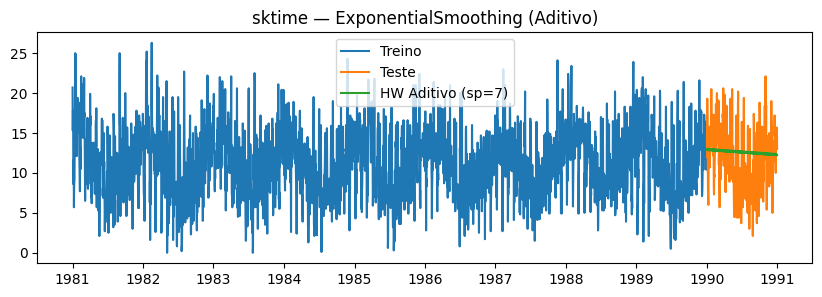

In [26]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon

y_train = train[COL_VALUE]
y_test  = test[COL_VALUE]
fh = ForecastingHorizon(np.arange(1, len(y_test)+1), is_relative=True)

# tendência aditiva + sazonalidade aditiva semanal (sp=7)
hw = ExponentialSmoothing(trend="add", seasonal="add", sp=7, use_boxcox=False)
hw.fit(y_train)

y_pred_hw = hw.predict(fh).to_numpy()

mae_hw  = mean_absolute_error(y_test.values, y_pred_hw)
rmse_hw = mean_squared_error(y_test.values, y_pred_hw, squared=False)
mase_hw = mase(y_test.values, y_pred_hw, y_train.values, m=1)

print(f"ExpSmoothing (A/A, sp=7) → MAE={mae_hw:.3f}  RMSE={rmse_hw:.3f}  MASE={mase_hw:.3f}")

plt.figure(figsize=(10,3))
plt.plot(train.index, y_train, label='Treino')
plt.plot(test.index,  y_test,  label='Teste')
plt.plot(test.index,  y_pred_hw, label='HW Aditivo (sp=7)')
plt.title("sktime — ExponentialSmoothing (Aditivo)")
plt.legend(); plt.show()


In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normaliza
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[COL_VALUE]].values)
test_scaled  = scaler.transform(test[[COL_VALUE]].values)

# Janela temporal
LOOKBACK = 30

def build_sequences(series, lookback=LOOKBACK):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i, 0])
        y.append(series[i, 0])
    X = np.array(X)[:, :, None]
    y = np.array(y)
    return X, y

X_train, y_train = build_sequences(train_scaled, LOOKBACK)
X_train.shape, y_train.shape


((3257, 30, 1), (3257,))

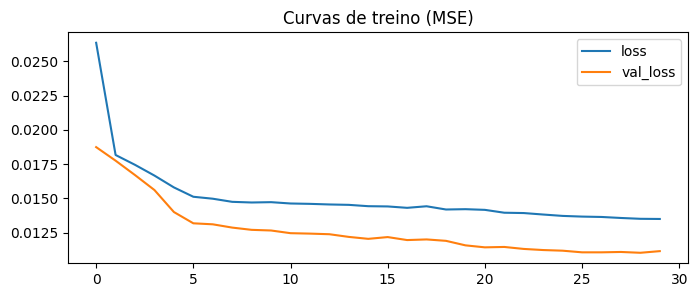

In [28]:
tf.keras.backend.clear_session()

model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8,3), title='Curvas de treino (MSE)')
plt.show()


LSTM → MAE=3.944  RMSE=4.841  MASE=1.456


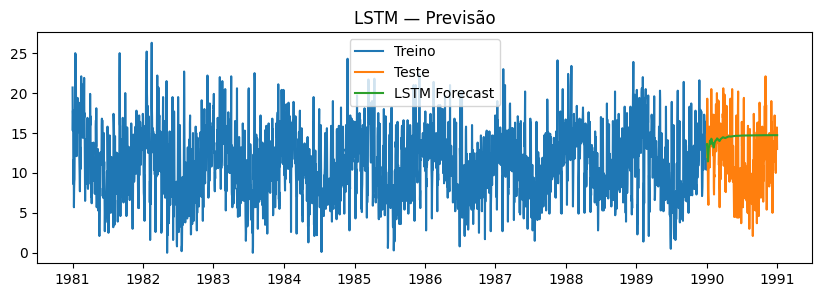

In [29]:
last_window = train_scaled[-LOOKBACK:].copy()
preds_scaled = []

for t in range(len(test_scaled)):
    x = last_window.reshape(1, LOOKBACK, 1)
    yhat_scaled = model.predict(x, verbose=0)[0,0]
    preds_scaled.append(yhat_scaled)

    last_window = np.vstack([last_window[1:], [[yhat_scaled]]])

# desfaz o scaling
yhat_lstm = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

# métricas
mae_lstm  = mae(test[COL_VALUE].values, yhat_lstm)
rmse_lstm = rmse(test[COL_VALUE].values, yhat_lstm)
mase_lstm = mase(test[COL_VALUE].values, yhat_lstm, train[COL_VALUE].values, m=1)

print(f"LSTM → MAE={mae_lstm:.3f}  RMSE={rmse_lstm:.3f}  MASE={mase_lstm:.3f}")

# plot
plt.figure(figsize=(10,3))
plt.plot(train.index, train[COL_VALUE], label='Treino')
plt.plot(test.index,  test[COL_VALUE],  label='Teste')
plt.plot(test.index,  yhat_lstm,        label='LSTM Forecast')
plt.title("LSTM — Previsão")
plt.legend(); plt.show()


ExpSmoothing → MAE=3.289, RMSE=3.941, MASE=1.214


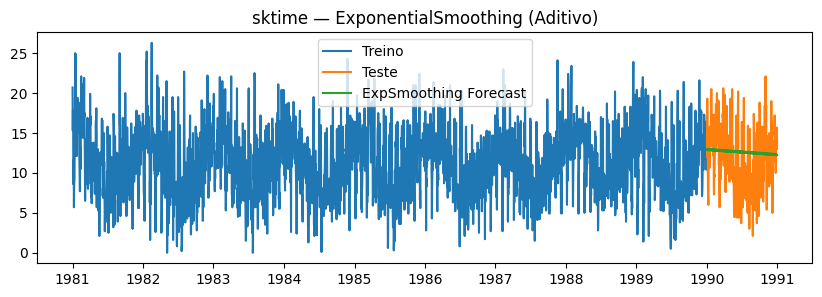

In [30]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

y_train = train[COL_VALUE]
y_test  = test[COL_VALUE]
fh = ForecastingHorizon(np.arange(1, len(y_test)+1), is_relative=True)

forecaster = ExponentialSmoothing(trend="add", seasonal="add", sp=7, use_boxcox=False)
forecaster.fit(y_train)
y_pred_theta = forecaster.predict(fh).to_numpy()

mae_theta  = mean_absolute_error(y_test.values, y_pred_theta)
rmse_theta = mean_squared_error(y_test.values, y_pred_theta, squared=False)
mase_theta = mase(y_test.values, y_pred_theta, y_train.values, m=1)

print(f"ExpSmoothing → MAE={mae_theta:.3f}, RMSE={rmse_theta:.3f}, MASE={mase_theta:.3f}")

plt.figure(figsize=(10,3))
plt.plot(train.index, y_train, label='Treino')
plt.plot(test.index,  y_test,  label='Teste')
plt.plot(test.index,  y_pred_theta, label='ExpSmoothing Forecast')
plt.title("sktime — ExponentialSmoothing (Aditivo)")
plt.legend(); plt.show()


,MAE,RMSE,MASE
Modelo,,,
sktime (Theta),3.289,3.941,1.214
LSTM,3.944,4.841,1.456


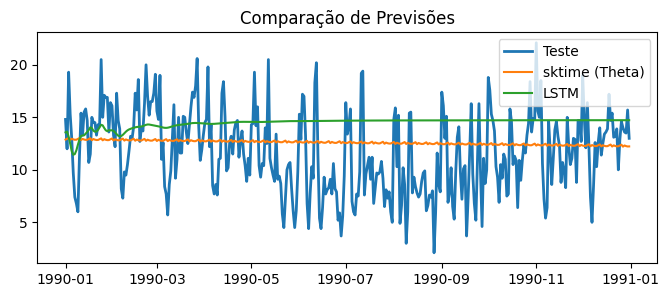

In [31]:
scores = pd.DataFrame({
    'Modelo': ['sktime (Theta)','LSTM'],
    'MAE':    [mae_theta, mae_lstm],
    'RMSE':   [rmse_theta, rmse_lstm],
    'MASE':   [mase_theta, mase_lstm],
}).set_index('Modelo')

display(scores.style.format("{:.3f}"))

plt.figure(figsize=(8,3))
plt.plot(test.index, test[COL_VALUE].values, label='Teste', linewidth=2)
plt.plot(test.index, y_pred_theta, label='sktime (Theta)')
plt.plot(test.index, yhat_lstm, label='LSTM')
plt.title("Comparação de Previsões")
plt.legend(); plt.show()


## Métricas e justificativa

- **MAE** (Mean Absolute Error): erro médio absoluto, fácil de interpretar (mesma unidade da série, °C).  
- **RMSE**: penaliza mais erros grandes (quadrático), útil quando queremos punir *outliers* de erro.  
- **MASE** (Mean Absolute Scaled Error): recomendado por Hyndman & Koehler (2006) como medida-padrão comparável entre séries;  
  evita problemas das métricas percentuais (MAPE/sMAPE) quando há valores próximos de zero (ou quando “%” não faz sentido, como em temperatura em °C).  
  Referências: Hyndman & Koehler (2006) e o livro *Forecasting: Principles and Practice* desaconselham o uso do sMAPE e preferem MASE para comparações.  :contentReference[oaicite:2]{index=2}

### Por que **não** usar MAPE/sMAPE aqui?
- Temperatura em °C pode ficar próxima de 0 → divisão por valores pequenos distorce percentuais.  
- sMAPE é assimétrico e tem propriedades indesejáveis documentadas por Hyndman.  :contentReference[oaicite:3]{index=3}
